<a href="https://colab.research.google.com/github/SilaTan/Multi-Class-Sentiment-Analysis-with-Bert-and-RoBerta/blob/master/Multi_Class_Sentiment_Analysis_with_Bert_and_RoBerta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [126]:
df_train = pd.read_csv("/content/drive/MyDrive/CSV UZANTILARIM/train.txt",delimiter=';',names=['text','label'])
df_test = pd.read_csv("/content/drive/MyDrive/CSV UZANTILARIM/val.txt",delimiter=';',names=['text','label'])

In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [128]:
df_train.drop_duplicates(subset='text',inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15969 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15969 non-null  object
 1   label   15969 non-null  object
dtypes: object(2)
memory usage: 374.3+ KB


In [129]:
df_test.drop_duplicates(subset='text',inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1998 non-null   object
 1   label   1998 non-null   object
dtypes: object(2)
memory usage: 46.8+ KB


In [130]:
df_train.label.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


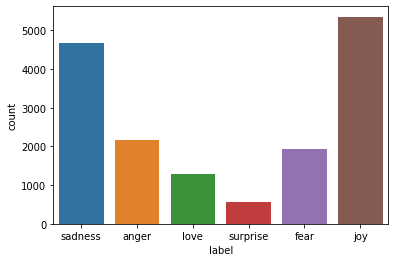

In [131]:
sns.countplot(df_train.label)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


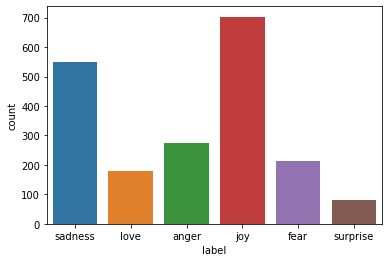

In [132]:
sns.countplot(df_test.label)

Aşağıdaki fonksiyon, elimizdeki verinin daha temiz olması için yapılan bir işlemdir.

The following function is an operation to make the data we have cleaner.


In [133]:
import re, string

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = text.replace('im', 'i am').replace('dont', 'do not').replace('didnt', 'did not').replace('doesnt', 'does not').replace('ive', 'i have')
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [134]:
texts_new = []
for t in df_train.text:
    texts_new.append((strip_all_entities(t)))

In [135]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append((strip_all_entities(t)))

In [136]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [137]:
df_train['text_clean'].head()

0                            i did not feel humiliated
1    i can go from feeling so hopeless to so damned...
2    i am grabbing a minute to post i feel greedy w...
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: text_clean, dtype: object

In [138]:
df_train.head()

,text,label,text_clean
0,i didnt feel humiliated,sadness,i did not feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,anger,i am grabbing a minute to post i feel greedy w...
3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,anger,i am feeling grouchy


In [139]:
df_test['text_clean'].head()

0    i am feeling quite sad and sorry for myself bu...
1    i feel like i am still looking at a blank canv...
2                       i feel like a faithful servant
3                    i am just feeling cranky and blue
4    i can have for a treat or if i am feeling fest...
Name: text_clean, dtype: object

Aşağıdaki fonksiyon, df_train için her metinde toplam kaç kelime olduğunu veriyor.

The following function gives the total number of words in each text for df_train.

In [140]:
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [141]:
df_train['text_len'] = text_len
df_train

,text,label,text_clean,text_len
0,i didnt feel humiliated,sadness,i did not feel humiliated,5
1,i can go from feeling so hopeless to so damned...,sadness,i can go from feeling so hopeless to so damned...,21
2,im grabbing a minute to post i feel greedy wrong,anger,i am grabbing a minute to post i feel greedy w...,11
3,i am ever feeling nostalgic about the fireplac...,love,i am ever feeling nostalgic about the fireplac...,18
4,i am feeling grouchy,anger,i am feeling grouchy,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,i just had a very brief ti ame in the beanbag ...,25
15996,i am now turning and i feel pathetic that i am...,sadness,i am now turning and i feel pathetic that i am...,20
15997,i feel strong and good overall,joy,i feel strong and good overall,6
15998,i feel like this was such a rude comment and i...,anger,i feel like this was such a rude comment and i...,15


In [142]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [143]:
df_test['text_len'] = text_len_test
df_test

,text,label,text_clean,text_len
0,im feeling quite sad and sorry for myself but ...,sadness,i am feeling quite sad and sorry for myself bu...,16
1,i feel like i am still looking at a blank canv...,sadness,i feel like i am still looking at a blank canv...,15
2,i feel like a faithful servant,love,i feel like a faithful servant,6
3,i am just feeling cranky and blue,anger,i am just feeling cranky and blue,7
4,i can have for a treat or if i am feeling festive,joy,i can have for a treat or if i am feeling fest...,13
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,i am having ssa examination tomorrow in the mo...,37
1996,i constantly worry about their fight against n...,joy,i constantly worry about their fight against n...,30
1997,i feel its important to share this info for th...,joy,i feel its i amportant to share this info for ...,16
1998,i truly feel that if you are passionate enough...,joy,i truly feel that if you are passionate enough...,19


In [144]:
print(max(df_train['text_len']))
print(min(df_train['text_len']))

71
2


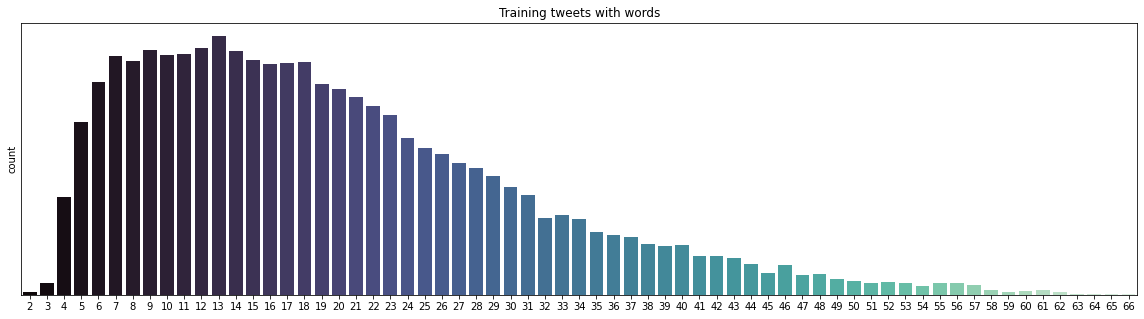

In [145]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<71], palette='mako')
plt.title('Training tweets with words')
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [146]:
# 3 kelimeden küçük cümleleri verimizden atıyoruz.
# We exclude sentences less than 3 words from our data.
df = df_train[df_train['text_len'] > 3]

In [147]:
# 32 kelimeden büyük cümleleri verimizden atıyoruz.
# We exclude sentences larger than 32 words from our data.
df = df[df['text_len'] < 32]

In [148]:
df.shape

(13580, 4)

In [149]:
print(max(df_test['text_len']))
print(min(df_test['text_len']))

64
2


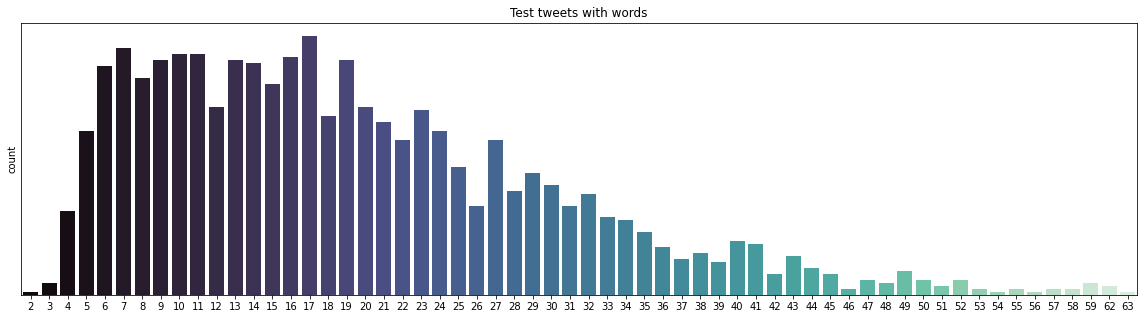

In [150]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<64], palette='mako')
plt.title('Test tweets with words')
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [151]:
# 3 kelimeden küçük cümleleri verimizden atıyoruz.
# We exclude sentences less than 3 words from our data.
df_test = df_test[df_test['text_len'] > 3]

In [152]:
# 35 kelimeden büyük cümleleri verimizden atıyoruz.
# We exclude sentences larger than 35 words from our data.
df_test = df_test[df_test['text_len'] < 35]

In [153]:
df_test.shape

(1797, 4)

# ***BERT***

In [154]:
!pip install transformers
import transformers

from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

**Training data deeper cleaning**

In [156]:
import numpy as np
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True) # 101   .....   .....   .....  102 
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 79


In [157]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>30:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 6, TEXT: i have been taking or milligrams or ti ames recommended amount and i have fallen asleep a lot faster but i also feel like so funny
INDEX: 21, TEXT: i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me
INDEX: 33, TEXT: i feel a bit rude writing to an elderly gentleman to ask for gifts because i feel a bit greedy but what is christmas about if not mild greed
INDEX: 36, TEXT: i already have my christmas trees up i got two and am feeling festi have which i m sure is spurring me to get started on this book
INDEX: 37, TEXT: i have worn it once on its own with a little concealer and for the days i am feeling brave but do not want to be pale then its perfect
INDEX: 39, TEXT: i was feeling so discouraged we are already robbing peter to pay paul to get our cow this year but we cant afford to not get the cow this way
INDEX: 50, TEXT: i have this feeling that if i have anymore vigorous sexual activity in t

In [158]:
df['token_lens'] = token_lens

In [159]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,label,text_clean,text_len,token_lens
14644,i feel lethargic and getting pressure between ...,sadness,i feel lethargic and getting pressure between ...,31,79
6284,i swamp uncaring unfeeling fucked up apathetic...,anger,i swamp uncaring unfeeling fucked up apathetic...,31,45
5763,i don t whoop and holler unless there s a spec...,joy,i don t whoop and holler unless there s a spec...,31,43
10418,i have to relate it to how a subject percieves...,sadness,i have to relate it to how a subject percieves...,30,42
6570,i feel cdm flac custodes title alibi how much ...,joy,i feel cdm flac custodes title alibi how much ...,29,42
5864,i know a lot of people are whining that a firs...,joy,i know a lot of people are whining that a firs...,31,42
4040,i dont know what guys could be doing doused in...,love,i do not know what guys could be doing doused ...,30,41
6930,ive been feeling a bit nostalgic ever since i ...,love,i have been feeling a bit nostalgic ever since...,29,41
9010,i feel the frames could give the works an eleg...,joy,i feel the frames could gi have the works an e...,31,41
10575,i resent you as much as i do that i feel needl...,anger,i resent you as much as i do that i feel needl...,28,41


In [160]:
df=df.drop(14644)
df = df.sort_values(by='token_lens', ascending=False)
df.head()

,text,label,text_clean,text_len,token_lens
6284,i swamp uncaring unfeeling fucked up apathetic...,anger,i swamp uncaring unfeeling fucked up apathetic...,31,45
5763,i don t whoop and holler unless there s a spec...,joy,i don t whoop and holler unless there s a spec...,31,43
10418,i have to relate it to how a subject percieves...,sadness,i have to relate it to how a subject percieves...,30,42
6570,i feel cdm flac custodes title alibi how much ...,joy,i feel cdm flac custodes title alibi how much ...,29,42
5864,i know a lot of people are whining that a firs...,joy,i know a lot of people are whining that a firs...,31,42


In [161]:
df = df.sample(frac=1).reset_index(drop=True)
# frac = 0.5 olunca 6790 satır dönüyor.
# frac = 1 olunca 13580
df

,text,label,text_clean,text_len,token_lens
0,i can also song write without feeling all bash...,fear,i can also song write without feeling all bash...,25,28
1,i doubles victory over brown struff we went ba...,joy,i doubles victory over brown struff we went ba...,26,33
2,i feel so weird that it feels like i wanna cur...,fear,i feel so weird that it feels like i wanna cur...,29,31
3,i feel like quitting rugby because i am ignored,sadness,i feel like quitting rugby because i am ignored,9,12
4,i mention this one doesn t feel fake,sadness,i mention this one doesn t feel fake,8,10
...,...,...,...,...,...
13574,i feel is a dull worry,sadness,i feel is a dull worry,6,8
13575,i feel reluctant to join the class trip to bei...,fear,i feel reluctant to join the class trip to bei...,10,12
13576,i feel pretty mellow so far about whatever hea...,joy,i feel pretty mellow so far about whatever hea...,15,18
13577,i know hes upset that ryan did this to me he l...,joy,i know hes upset that ryan did this to me he l...,29,32


**Testing data deeper cleaning**

In [162]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [163]:
print(df_test.shape)

(1797, 4)


In [164]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 62


In [165]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>30:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 15, TEXT: i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others
INDEX: 24, TEXT: i don t know if anybody will ever be able to feel how i feel or at least relate when everything is lost you find yourself missing and longing for it them
INDEX: 30, TEXT: i have found in the past when i blog daily i have more to say and i get out my feelings and emotions in more creati have ways
INDEX: 31, TEXT: i to candy factory it was clearly a tourist production line but it didn t feel unpleasant or hurried just well planned and professional an interesting and picturesque visit
INDEX: 32, TEXT: i feel that i m so pathetic and downright dumb to let people in let them toy with my feelings and then leaving me to clean up this pile of sadness inside me
INDEX: 38, TEXT: i sit the chicken preferably bone in chicken thighs skinless because i feel they have the most flavor in a 

In [166]:
df_test['token_lens'] = token_lens_test

In [167]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,text,label,text_clean,text_len,token_lens
197,i feel so cool like ice t huhwe neun gatda beo...,joy,i feel so cool like ice t huhwe neun gatda beo...,31,62
913,i am feeling extremely devastated right now be...,sadness,i am feeling extremely devastated right now be...,34,45
675,ive been disregarded devalued or heartbroken o...,joy,i have been disregarded devalued or heartbroke...,34,43
1541,i think hes well aware of the internets reacti...,fear,i think hes well aware of the internets reacti...,31,42
171,id been feeling a bit funny all day verging on...,surprise,id been feeling a bit funny all day verging on...,34,41
50,i could smell the chlorine feel my aching musc...,sadness,i could smell the chlorine feel my aching musc...,29,41
1315,i get a day off from writing and feeling press...,surprise,i get a day off from writing and feeling press...,33,41
625,i feel unwelcome in this town as if my time he...,sadness,i feel unwelcome in this town as if my ti ame ...,30,40
696,i type this i can see my unacceptably huge muf...,anger,i type this i can see my unacceptably huge muf...,34,40
1304,i feel not just attracted to but completely en...,surprise,i feel not just attracted to but completely en...,32,40


In [168]:
df_test=df_test.drop(197)
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head()

,text,label,text_clean,text_len,token_lens
913,i am feeling extremely devastated right now be...,sadness,i am feeling extremely devastated right now be...,34,45
675,ive been disregarded devalued or heartbroken o...,joy,i have been disregarded devalued or heartbroke...,34,43
1541,i think hes well aware of the internets reacti...,fear,i think hes well aware of the internets reacti...,31,42
171,id been feeling a bit funny all day verging on...,surprise,id been feeling a bit funny all day verging on...,34,41
50,i could smell the chlorine feel my aching musc...,sadness,i could smell the chlorine feel my aching musc...,29,41


In [169]:
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test

,text,label,text_clean,text_len,token_lens
0,i often feel dissatisfied when i don t have at...,anger,i often feel dissatisfied when i don t have at...,15,17
1,i suppose it all goes along with feeling unwel...,sadness,i suppose it all goes along with feeling unwel...,13,20
2,i know you re only doing this because i want i...,sadness,i know you re only doing this because i want i...,21,25
3,i feel cheated and at another i feel ashamed t...,sadness,i feel cheated and at another i feel ashamed t...,16,18
4,i feel it my solemn duty to warn you,joy,i feel it my solemn duty to warn you,9,11
...,...,...,...,...,...
1791,i feel lucky to have escaped without worse con...,joy,i feel lucky to have escaped without worse con...,9,11
1792,i was a little sprog and feeling all throw up ...,sadness,i was a little sprog and feeling all throw up ...,33,38
1793,i had struggled through a difficult pregnancy ...,fear,i had struggled through a difficult pregnancy ...,29,35
1794,i just need a few minutes to feel put upon and...,sadness,i just need a few minutes to feel put upon and...,17,20


In [170]:
df['label'].value_counts()

joy         4543
sadness     4030
anger       1802
fear        1655
love        1076
surprise     473
Name: label, dtype: int64

Aşağıdaki iki satır, df ve df_test veri setlerindeki çıktı/etiket olarak nitelendirdiğimiz sütunun metin halinden sayısal hale geçmesini sağlıyor.

The following two lines make the column we refer to as output/label in the df and df_test datasets, from text to numeric.

One Hot Encoding ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.

One Hot Encoding requires categorical values to be mapped to integer values first.

In [171]:
df['label'] = df['label'].map({'joy':0,'love':1,'surprise':2,'sadness':3,'anger':4,'fear':5})

In [172]:
df_test['label'] = df_test['label'].map({'joy':0,'love':1,'surprise':2,'sadness':3,'anger':4,'fear':5})

In [173]:
df['label'].value_counts()

0    4543
3    4030
4    1802
5    1655
1    1076
2     473
Name: label, dtype: int64

In [174]:
df_test.head()

,text,label,text_clean,text_len,token_lens
0,i often feel dissatisfied when i don t have at...,4,i often feel dissatisfied when i don t have at...,15,17
1,i suppose it all goes along with feeling unwel...,3,i suppose it all goes along with feeling unwel...,13,20
2,i know you re only doing this because i want i...,3,i know you re only doing this because i want i...,21,25
3,i feel cheated and at another i feel ashamed t...,3,i feel cheated and at another i feel ashamed t...,16,18
4,i feel it my solemn duty to warn you,0,i feel it my solemn duty to warn you,9,11


In [175]:
df[df['label'] ==2]

,text,label,text_clean,text_len,token_lens
5,i just feel more dazed and alone in the end,2,i just feel more dazed and alone in the end,10,12
114,i feel about it has me shocked,2,i feel about it has me shocked,7,9
119,i learned about taking a dip in the dating poo...,2,i learned about taking a dip in the dating poo...,22,24
126,i would be feeling i am genuinely shocked and ...,2,i would be feeling i am genuinely shocked and ...,15,17
128,i was feeling an act of god at work in my life...,2,i was feeling an act of god at work in my life...,18,20
...,...,...,...,...,...
13468,i stood kind of dumbfounded looking around fee...,2,i stood kind of dumbfounded looking around fee...,10,13
13472,i ini i feel strange,2,i ini i feel strange,5,8
13488,i get that sick feeling like the one you get w...,2,i get that sick feeling like the one you get w...,29,35
13550,i dont mean to boast but i feel rather impress...,2,i do not mean to boast but i feel rather i amp...,15,19


**Class Balancing by RandomOverSampler**

Random Oversampling: Randomly duplicate examples in the minority class.

Random Undersampling: Randomly delete examples in the majority class.

In [176]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [177]:
df['text_clean']

0        i can also song write without feeling all bash...
1        i doubles victory over brown struff we went ba...
2        i feel so weird that it feels like i wanna cur...
3          i feel like quitting rugby because i am ignored
4                     i mention this one doesn t feel fake
                               ...                        
13574                               i feel is a dull worry
13575    i feel reluctant to join the class trip to bei...
13576    i feel pretty mellow so far about whatever hea...
13577    i know hes upset that ryan did this to me he l...
13578              i left it feeling entertained but empty
Name: text_clean, Length: 13579, dtype: object

In [178]:
deneme = np.array(df['text_clean']).reshape(-1)
deneme

array(['i can also song write without feeling all bashful about it and play music and my guitars without anyone telling me to turn it down',
       'i doubles victory over brown struff we went back on sunday feeling really opti amistic and looking forward to another day filled with more fedtastic tennis',
       'i feel so weird that it feels like i wanna curse everything and bang my head onto the wall so that my world will be back to its focus',
       ...,
       'i feel pretty mellow so far about whatever healing wounding process may be getting underway',
       'i know hes upset that ryan did this to me he liked hi am when he met hi am and he even thought his feelings for me were sincere',
       'i left it feeling entertained but empty'], dtype=object)

In [179]:
deneme = np.array(df['text_clean']).reshape(-1,1)
deneme

array([['i can also song write without feeling all bashful about it and play music and my guitars without anyone telling me to turn it down'],
       ['i doubles victory over brown struff we went back on sunday feeling really opti amistic and looking forward to another day filled with more fedtastic tennis'],
       ['i feel so weird that it feels like i wanna curse everything and bang my head onto the wall so that my world will be back to its focus'],
       ...,
       ['i feel pretty mellow so far about whatever healing wounding process may be getting underway'],
       ['i know hes upset that ryan did this to me he liked hi am when he met hi am and he even thought his feelings for me were sincere'],
       ['i left it feeling entertained but empty']], dtype=object)

In [180]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['label']).reshape(-1, 1));

In [ ]:
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'label']);
train_os

,text_clean,label
0,i feel that i was damaged by gt gt gt religion...,3
1,i feel so violent just want to break some glass,4
2,i still feel quite amazed at how silent snow i...,2
3,i feel isolated unnatural yeah i feel tense un...,3
4,i have to admit i am feeling a bit inti amidat...,5
...,...,...
27253,i am so stoned on endorphin that all i can fee...,5
27254,i just mean it in a logistics sort of way i fe...,5
27255,i recall seeing leaves falling off a tree set ...,5
27256,i could feel what was going to happen at the v...,5


In [ ]:
train_os['label'].value_counts()

3    4543
4    4543
2    4543
5    4543
0    4543
1    4543
Name: label, dtype: int64

**Train - Validation - Test split**

In [ ]:
X = train_os['text_clean'].values
y = train_os['label'].values

In [ ]:
X.shape

(27258,)

In [181]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [182]:
X_test = df_test['text_clean'].values
y_test = df_test['label'].values

**One hot encoding**

In [183]:
from sklearn import preprocessing

In [184]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [185]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [195]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.]])

In [186]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 24532
VALIDATION DATA: 2726
TESTING DATA: 1796


**Baseline model: Naive Bayes Classifier**

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [189]:
clf = CountVectorizer()

#  text = ["John is a good boy. John watches basketball"]

#  vectorizer.fit(text) !! for tokenize and build vocab
#  print(vectorizer.vocabulary_)  --> {'is': 3, 'good': 2, 'boy': 1, 'watches': 5, 'john': 4, 'basketball': 0}

#  vector = vectorizer.transform(text)  !!encode document
#  print(vector.shape) --> (1, 6)
#  print(vector.toarray())  --> [[1 1 1 1 2 1]]

X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [190]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [191]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [192]:
nb_pred = nb_clf.predict(X_test_tf)

In [193]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [194]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['joy','love','surprise','sadness','anger','fear']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

         joy       0.94      0.82      0.87       624
        love       0.65      0.82      0.73       157
    surprise       0.47      0.76      0.58        76
     sadness       0.91      0.86      0.89       504
       anger       0.85      0.84      0.84       241
        fear       0.74      0.82      0.78       194

    accuracy                           0.83      1796
   macro avg       0.76      0.82      0.78      1796
weighted avg       0.85      0.83      0.84      1796



**BERT Sentiment Analysis**

In [196]:
def tokenize(data,max_len=128) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i], # the row
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids']) # [101 ..... ..... ..... 102]
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [197]:
train_input_ids, train_attention_masks = tokenize(X_train, 128)
val_input_ids, val_attention_masks = tokenize(X_valid, 128)
test_input_ids, test_attention_masks = tokenize(X_test, 128)

**BERT modeling**

In [198]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [199]:
import tensorflow as tf
from tensorflow import keras

In [200]:
def create_model(bert_model, max_len=128):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(6, activation="softmax")(embeddings)  ## Kaç tane output varsa o kadar sayı (6)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [201]:
model = create_model(bert_model, 128)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [202]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
767/767 [==============================] - 653s 831ms/step - loss: 0.6673 - categorical_accuracy: 0.7438 - val_loss: 0.1331 - val_categorical_accuracy: 0.9501
Epoch 2/4
767/767 [==============================] - 641s 836ms/step - loss: 0.1274 - categorical_accuracy: 0.9526 - val_loss: 0.0967 - val_categorical_accuracy: 0.9644
Epoch 3/4
767/767 [==============================] - 642s 837ms/step - loss: 0.0751 - categorical_accuracy: 0.9722 - val_loss: 0.0641 - val_categorical_accuracy: 0.9776
Epoch 4/4
767/767 [==============================] - 640s 835ms/step - loss: 0.0480 - categorical_accuracy: 0.9826 - val_loss: 0.0476 - val_categorical_accuracy: 0.9857


In [203]:
result_bert = model.predict([test_input_ids,test_attention_masks])
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [204]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert,  target_names=['joy','love','surprise','sadness','anger','fear']))

	Classification Report for BERT:

               precision    recall  f1-score   support

         joy       0.96      0.96      0.96       624
        love       0.91      0.85      0.88       157
    surprise       0.85      0.87      0.86        76
     sadness       0.95      0.97      0.96       504
       anger       0.93      0.95      0.94       241
        fear       0.89      0.84      0.86       194

   micro avg       0.93      0.93      0.93      1796
   macro avg       0.91      0.91      0.91      1796
weighted avg       0.93      0.93      0.93      1796
 samples avg       0.93      0.93      0.93      1796



In [205]:
confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))

array([[598,  13,   3,   5,   1,   4],
       [ 20, 133,   0,   3,   1,   0],
       [  2,   0,  66,   1,   0,   7],
       [  4,   0,   0, 489,   7,   4],
       [  1,   0,   0,   6, 229,   5],
       [  1,   0,   9,  12,   9, 163]])

**RoBERTa Sentiment Analysis**

In [206]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [207]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

42

In [208]:
def tokenize_roberta(data,max_len=128) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [209]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, 128)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, 128)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, 128)

In [210]:
def create_model(bert_model, max_len=128):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(6, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [211]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [212]:
model = create_model(roberta_model, 128)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [213]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
767/767 [==============================] - 664s 846ms/step - loss: 0.5017 - categorical_accuracy: 0.8099 - val_loss: 0.1494 - val_categorical_accuracy: 0.9453
Epoch 2/4
767/767 [==============================] - 645s 841ms/step - loss: 0.1521 - categorical_accuracy: 0.9440 - val_loss: 0.1168 - val_categorical_accuracy: 0.9615
Epoch 3/4
767/767 [==============================] - 646s 842ms/step - loss: 0.1109 - categorical_accuracy: 0.9574 - val_loss: 0.1044 - val_categorical_accuracy: 0.9663
Epoch 4/4
767/767 [==============================] - 644s 840ms/step - loss: 0.0854 - categorical_accuracy: 0.9660 - val_loss: 0.0802 - val_categorical_accuracy: 0.9751


In [214]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

In [215]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [216]:
confusion_matrix(y_test.argmax(1), y_pred_roberta.argmax(1))

array([[577,  38,   4,   1,   2,   2],
       [  4, 152,   0,   1,   0,   0],
       [  2,   0,  66,   2,   0,   6],
       [  2,   1,   0, 477,  10,  14],
       [  0,   1,   0,   7, 226,   7],
       [  1,   0,   5,   6,   4, 178]])

In [217]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['joy','love','surprise','sadness','anger','fear']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

         joy       0.98      0.92      0.95       624
        love       0.79      0.97      0.87       157
    surprise       0.88      0.87      0.87        76
     sadness       0.97      0.95      0.96       504
       anger       0.93      0.94      0.94       241
        fear       0.86      0.92      0.89       194

   micro avg       0.93      0.93      0.93      1796
   macro avg       0.90      0.93      0.91      1796
weighted avg       0.94      0.93      0.93      1796
 samples avg       0.93      0.93      0.93      1796

